# **1. Introduction et préparation**

## **1.1. Importation des packages et données nécessaires**

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
from scipy.optimize import minimize

In [204]:
# Définir la période d'analyse sur 10 ans
end_date = '2025-01-01'
start_date = '2015-01-01'

In [205]:
# Les 5 entreprises automobiles et le benchmark global : MSCI World.
tickers = ['STLA', 'TM', 'VOW.DE', 'F', 'GM']
tickers2 =['STLA', 'TM', 'VOW.DE', 'F', 'GM','^990100-USD-STRD']
names = ['Stellantis', 'Toyota', 'Volkswagen', 'Ford', 'General Motors']
names2 = ['Stellantis', 'Toyota', 'Volkswagen', 'Ford', 'General Motors','MSCI World']

In [206]:
# Téléchargement des données
df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Close']
df = df[tickers]
df.columns = names
print(df)

[*********************100%***********************]  5 of 5 completed

            Stellantis      Toyota  Volkswagen   Ford  General Motors
Date                                                                 
2015-01-02    7.690789  125.669998  177.949997  15.36       34.840000
2015-01-05    7.401316  123.370003  172.550003  14.76       34.330002
2015-01-06    7.625000  122.099998  173.949997  14.62       34.849998
2015-01-07    7.618421  125.169998  174.800003  15.04       35.840000
2015-01-08    7.690789  127.580002  181.550003  15.42       36.200001
...                ...         ...         ...    ...             ...
2024-12-24   13.070000  181.429993         NaN  10.02       53.509998
2024-12-26   13.020000  197.360001         NaN  10.07       54.180000
2024-12-27   13.070000  199.520004   91.349998  10.03       54.279999
2024-12-30   13.040000  195.660004   92.150002   9.88       53.660000
2024-12-31   13.050000  194.610001         NaN   9.90       53.270000

[2582 rows x 5 columns]


In [207]:
# Téléchargement des données avec MSCI World
df2 = yf.download(tickers2, start=start_date, end=end_date, auto_adjust=False)['Close']
df2 = df2[tickers2]
df2.columns = names2
print(df2)

[*********************100%***********************]  6 of 6 completed

            Stellantis      Toyota  Volkswagen   Ford  General Motors  \
Date                                                                    
2015-01-02    7.690789  125.669998  177.949997  15.36       34.840000   
2015-01-05    7.401316  123.370003  172.550003  14.76       34.330002   
2015-01-06    7.625000  122.099998  173.949997  14.62       34.849998   
2015-01-07    7.618421  125.169998  174.800003  15.04       35.840000   
2015-01-08    7.690789  127.580002  181.550003  15.42       36.200001   
...                ...         ...         ...    ...             ...   
2024-12-24   13.070000  181.429993         NaN  10.02       53.509998   
2024-12-26   13.020000  197.360001         NaN  10.07       54.180000   
2024-12-27   13.070000  199.520004   91.349998  10.03       54.279999   
2024-12-30   13.040000  195.660004   92.150002   9.88       53.660000   
2024-12-31   13.050000  194.610001         NaN   9.90       53.270000   

             MSCI World  
Date                    

## **1.2. Vérification de l'intégrité et la fiabilité des données**

In [208]:
# Vérifier les données (Stellantis étant plus récent que 10 ans, nous devrons gérer les valeurs manquantes)
print(df.isnull().sum())
print(df2.isnull().sum())

Stellantis        66
Toyota            66
Volkswagen        40
Ford              66
General Motors    66
dtype: int64
Stellantis        66
Toyota            66
Volkswagen        40
Ford              66
General Motors    66
MSCI World        69
dtype: int64


In [209]:
# Afficher les premières dates disponibles pour chaque action
for col in df.columns:
        first_valid = df[col].first_valid_index()
        if first_valid:
            print(f"{col}: Premières données disponibles à partir de {first_valid.strftime('%d-%m-%Y')}")

Stellantis: Premières données disponibles à partir de 02-01-2015
Toyota: Premières données disponibles à partir de 02-01-2015
Volkswagen: Premières données disponibles à partir de 02-01-2015
Ford: Premières données disponibles à partir de 02-01-2015
General Motors: Premières données disponibles à partir de 02-01-2015


In [210]:
# Commencer l'analyse à partir de la date où toutes les données sont disponibles
first_complete_row = df.dropna().index[0]
print(f"Analyse débutant à partir de {first_complete_row.strftime('%d-%m-%Y')} (toutes les données disponibles)")
df = df.loc[first_complete_row:]

Analyse débutant à partir de 02-01-2015 (toutes les données disponibles)


In [211]:
# Afficher la taille des données
print(f"Période d'analyse: {df.index[0].strftime('%d-%m-%Y')} à {df.index[-1].strftime('%d-%m-%Y')}")
print(f"Nombre total de jours de trading: {len(df)}")

Période d'analyse: 02-01-2015 à 31-12-2024
Nombre total de jours de trading: 2582


# **2. Analyse sélective des actions choisies**

## **2.1. Calcul des rentabilités (journalières, mensuelles, trimestrielles et annualisés)**

In [212]:
# Calculer les rendements journaliers
returns = df.pct_change().dropna()
print(returns)
returns2 = df2.pct_change().dropna()
print(returns2['MSCI World'])

            Stellantis    Toyota  Volkswagen      Ford  General Motors
Date                                                                  
2015-01-05   -0.037639 -0.018302   -0.030346 -0.039062       -0.014638
2015-01-06    0.030222 -0.010294    0.008114 -0.009485        0.015147
2015-01-07   -0.000863  0.025143    0.004886  0.028728        0.028408
2015-01-08    0.009499  0.019254    0.038616  0.025266        0.010045
2015-01-09    0.013687 -0.011757   -0.022583 -0.013619       -0.016851
...                ...       ...         ...       ...             ...
2024-12-24    0.012393  0.005431    0.000000  0.012121        0.018075
2024-12-26   -0.003825  0.087803    0.000000  0.004990        0.012521
2024-12-27    0.003840  0.010944    0.021241 -0.003972        0.001846
2024-12-30   -0.002295 -0.019346    0.008758 -0.014955       -0.011422
2024-12-31    0.000767 -0.005366    0.000000  0.002024       -0.007268

[2581 rows x 5 columns]
Date
2015-01-05   -0.019593
2015-01-06   -0.010112
2

/var/folders/jz/vlnsqnl50w13rpz964my6q4m0000gn/T/ipykernel_18519/223672511.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change().dropna()
/var/folders/jz/vlnsqnl50w13rpz964my6q4m0000gn/T/ipykernel_18519/223672511.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns2 = df2.pct_change().dropna()


In [213]:
# Les rendements mensuels
monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
print(monthly_returns)

/var/folders/jz/vlnsqnl50w13rpz964my6q4m0000gn/T/ipykernel_18519/3349153418.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)


            Stellantis    Toyota  Volkswagen      Ford  General Motors
Date                                                                  
2015-01-31    0.130026  0.025304    0.107895 -0.042318       -0.063720
2015-02-28    0.166541  0.050601    0.122749  0.110809        0.143777
2015-03-31    0.058404  0.033390    0.084482 -0.012240        0.005092
2015-04-30   -0.095647 -0.006219   -0.053114 -0.021066       -0.065067
2015-05-31    0.086780 -0.008128   -0.034316 -0.039873        0.025955
...                ...       ...         ...       ...             ...
2024-08-31    0.005392 -0.019375   -0.074244  0.034196        0.123195
2024-09-30   -0.162694 -0.059168   -0.006931 -0.056300       -0.099237
2024-10-31   -0.030605 -0.031080   -0.087737 -0.025568        0.132025
2024-11-30   -0.030837 -0.013813   -0.088525  0.081633        0.095154
2024-12-31   -0.011364  0.140538    0.104916 -0.110512       -0.041734

[120 rows x 5 columns]


In [214]:
# Les rendements trimestriels
quarterly_returns = returns.resample('Q').apply(lambda x: (1 + x).prod() - 1)
print(quarterly_returns)

/var/folders/jz/vlnsqnl50w13rpz964my6q4m0000gn/T/ipykernel_18519/12345171.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_returns = returns.resample('Q').apply(lambda x: (1 + x).prod() - 1)


            Stellantis    Toyota  Volkswagen      Ford  General Motors
Date                                                                  
2015-03-31    0.395210  0.113154    0.348974  0.050781        0.076349
2015-06-30   -0.109135 -0.043892   -0.135388 -0.070012       -0.111200
2015-09-30   -0.090847 -0.123140   -0.494339 -0.095936       -0.099310
2015-12-31    0.059046  0.049113    0.355884  0.038320        0.132911
2016-03-31   -0.124289 -0.135891   -0.103654 -0.041874       -0.075860
2016-06-30   -0.240695 -0.059537   -0.056056 -0.068889       -0.099586
2016-09-30    0.045752  0.160716    0.072674 -0.039777        0.122615
2016-12-31    0.425000  0.009823    0.058846  0.004971        0.096632
2017-03-31    0.198465 -0.073208    0.021207 -0.040396        0.014925
2017-06-30   -0.027447 -0.033143   -0.027927 -0.038660       -0.012161
2017-09-30    0.684854  0.134736    0.055249  0.069705        0.156026
2017-12-31   -0.003908  0.067131    0.177661  0.043442        0.015107
2018-0

In [215]:
# Calculer les rendements annualisés
annual_returns = returns.mean() * 252
print(annual_returns)

annual_returns2 = returns2.mean() * 252
print(annual_returns2['MSCI World'])

Stellantis        0.129832
Toyota            0.067030
Volkswagen       -0.003979
Ford              0.020295
General Motors    0.102913
dtype: float64
0.08724931323557061


## **2.2. Analyses statistique et définition des données de marché**

In [216]:
# Calculer la matrice de covariance (annualisée)
cov_matrix = returns.cov() * 252
cov_matrix2 = returns2.cov() * 252
print(cov_matrix)
print(cov_matrix2)

                Stellantis    Toyota  Volkswagen      Ford  General Motors
Stellantis        0.154938  0.040965    0.071099  0.076343        0.080214
Toyota            0.040965  0.048722    0.026153  0.035591        0.035930
Volkswagen        0.071099  0.026153    0.120238  0.048052        0.049860
Ford              0.076343  0.035591    0.048052  0.126324        0.094235
General Motors    0.080214  0.035930    0.049860  0.094235        0.123018
                Stellantis    Toyota  Volkswagen      Ford  General Motors  \
Stellantis        0.154938  0.040965    0.071099  0.076343        0.080214   
Toyota            0.040965  0.048722    0.026153  0.035591        0.035930   
Volkswagen        0.071099  0.026153    0.120238  0.048052        0.049860   
Ford              0.076343  0.035591    0.048052  0.126324        0.094235   
General Motors    0.080214  0.035930    0.049860  0.094235        0.123018   
MSCI World        0.036030  0.020318    0.024638  0.031768        0.032712   

   

In [217]:
# Calcule du Risk Free Rate et du Benchmark

# Option 1 : Calcul du Rf à partir de la moyenne :
  #risk_free_ticker = '^TNX'
  #risk_free_data = yf.download(risk_free_ticker, start=start_date, end=end_date)['Close'] / 100  # Conversion en décimal
  #risk_free_rate = risk_free_data.mean()
  #print(risk_free_rate)

# Option 2 : Choix du Rf à partir d'un taux actuel :
risk_free_rate = 0.025 #Hypothèse que le taux sans risque est le taux Euribor 3 mois constant actuel (~2,5%)

# Calcul de la rentabilité du marché (Benchmark) :
market_return = annual_returns2["MSCI World"]

In [218]:
print(f'Rendement sans risque du marché sur 10 ans est de {round(risk_free_rate*100,2)}%')
print(f'Hypothèse de rendement du marché sur 10 ans est de {round(market_return*100,2)}%')

Rendement sans risque du marché sur 10 ans est de 2.5%
Hypothèse de rendement du marché sur 10 ans est de 8.72%


In [219]:
# Créer un DataFrame pour stocker les résultats
analysis_results = pd.DataFrame(index=names)
analysis_results2 = pd.DataFrame(index=names2)

## **2.3. Résumé des principaux indicateurs de chaque entreprise**

In [220]:
# Stocker les résultats dans un dictionnaire
results = {}
for ticker in names:
    # Calcul du Beta
    beta = returns[ticker].cov(returns.mean(axis=1)) / returns.mean(axis=1).var()

    results[ticker] = {
        "Rendement Annualisé": annual_returns[ticker],
        "Risque (Volatilité)": np.sqrt(cov_matrix.loc[ticker, ticker]),
        "Ratio de Sharpe": (annual_returns[ticker] - risk_free_rate) / np.sqrt(cov_matrix.loc[ticker, ticker]),
        "Beta": beta,  # Store the calculated Beta
        "Alpha": annual_returns[ticker] - (risk_free_rate + beta * (market_return - risk_free_rate))
       }

# Créer un DataFrame à partir du dictionnaire pour l'affichage tabulaire
df_results = pd.DataFrame(results).T

# Afficher le tableau
print(df_results)

# Assigner les colonnes calculées à analysis_results
analysis_results['Rendement Annualisé'] = df_results['Rendement Annualisé']
analysis_results['Risque (Volatilité)'] = df_results['Risque (Volatilité)']
analysis_results['Ratio de Sharpe'] = df_results['Ratio de Sharpe']
analysis_results['Beta'] = df_results['Beta']
analysis_results['Alpha'] = df_results['Alpha']

                Rendement Annualisé  Risque (Volatilité)  Ratio de Sharpe  \
Stellantis                 0.129832             0.393621         0.266327   
Toyota                     0.067030             0.220731         0.190413   
Volkswagen                -0.003979             0.346754        -0.083573   
Ford                       0.020295             0.355420        -0.013239   
General Motors             0.102913             0.350739         0.222139   

                    Beta     Alpha  
Stellantis      1.253042  0.026831  
Toyota          0.554280  0.007526  
Volkswagen      0.933076 -0.087063  
Ford            1.125790 -0.074785  
General Motors  1.133812  0.007334  


# **3. Optimisation du portefeuille selon Markowitz**

## **3.1. Rentabilités et principaux ratios du portefeuille**

In [221]:
# Fonction pour calculer les rendements et risques du portefeuille
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.sum(returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk


# Définition des poids équipondérés pour chaque action
sample_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Appel de fonction pour calculer les rendements et risques du portefeuille
portfolio_return, portfolio_risk = portfolio_performance(sample_weights, annual_returns, cov_matrix)

print(f"Rendement du portefeuille: {portfolio_return:.4f}")
print(f"Risque du portefeuille: {portfolio_risk:.4f}")


Rendement du portefeuille: 0.0632
Risque du portefeuille: 0.2600


In [222]:
# Fonction objectif: maximiser le ratio de Sharpe
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_risk = portfolio_performance(weights, returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# calcul du ratio de sharpe
portfolio_return, portfolio_risk = portfolio_performance(sample_weights, annual_returns, cov_matrix)
portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_risk


print(f"Ratio de Sharpe du portefeuille: {portfolio_sharpe:.4f}")

Ratio de Sharpe du portefeuille: 0.1470


## **3.2. Optimisation du poids des actifs au sein du portefeuille**

In [223]:
# Contraintes: somme des poids = 1 (pas de cash détenu)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Limites: poids entre 0 et 1 (pas de vente à découvert)
bounds = tuple((0, 1) for asset in range(len(names)))

# Optimisation
initial_weights = np.array([1/len(names)] * len(names))
print(initial_weights)
optimal_weights = minimize(neg_sharpe_ratio, initial_weights,
                         args=(annual_returns, cov_matrix, risk_free_rate),
                         method='SLSQP', bounds=bounds, constraints=constraints)
print(optimal_weights)

[0.2 0.2 0.2 0.2 0.2]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.28398886374952836
       x: [ 4.784e-01  2.822e-01  0.000e+00  0.000e+00  2.394e-01]
     nit: 5
     jac: [-8.789e-02 -8.833e-02  2.017e-01  1.719e-01 -8.789e-02]
    nfev: 30
    njev: 5


Nous avons démarré notre répartition de façon équipondéré (20% dans chaque action) puis, à l'aide d'une fonction d'optimisation et minimisation du risque, nous optenons une répartition ajustée.

In [224]:
# Récupérer les poids optimaux
optimal_portfolio = pd.DataFrame(index=names, data={'Poids Optimal': optimal_weights['x']})
print(optimal_portfolio)

                Poids Optimal
Stellantis           0.478447
Toyota               0.282181
Volkswagen           0.000000
Ford                 0.000000
General Motors       0.239372


In [225]:
#Vérification des poids optimaux sous contrainte
print(f"Somme des poids: {optimal_weights['x'].sum():.4f}")

Somme des poids: 1.0000


Les poids sont bien valides car on retrouve une égalité à 1 en faisant la somme. De plus, aucun poids n'est négatif donc il n'y a pas de vente à découvert. En résumé, nous avons donc une répartition en pourcentage telle que :

In [226]:
# Récupérer les poids optimaux en pourcent
print(optimal_portfolio*100)

                Poids Optimal
Stellantis          47.844669
Toyota              28.218103
Volkswagen           0.000000
Ford                 0.000000
General Motors      23.937228


## **3.3. Performances et principaux ratios du portefeuille optimisé**

In [227]:
# Calculer la performance du portefeuille optimisé
portfolio_return, portfolio_risk = portfolio_performance(optimal_weights['x'], annual_returns, cov_matrix)
portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_risk
print(f"Rendement du portefeuille: {portfolio_return:.4f}")
print(f"Risque du portefeuille: {portfolio_risk:.4f}")
print(f"Ratio de Sharpe du portefeuille: {portfolio_sharpe:.4f}")

Rendement du portefeuille: 0.1057
Risque du portefeuille: 0.2840
Ratio de Sharpe du portefeuille: 0.2840


In [228]:
# Générer la frontière efficiente
target_returns = np.linspace(annual_returns.min(), annual_returns.max(), 100)
efficient_portfolios = []

In [230]:
# Calculer le rendement cumulatif pour mesurer la performance sur 10 ans
cumulative_returns = (1 + returns).cumprod()
cumulative_returns2 = (1 + returns2).cumprod()
total_returns = (df.iloc[-1] / df.iloc[0] - 1) * 100
total_returns2 = (df2.iloc[-1] / df2.iloc[0] - 1) * 100
print(total_returns)
print(total_returns2['MSCI World'])

Stellantis        69.683498
Toyota            54.857964
Volkswagen              NaN
Ford             -35.546876
General Motors    52.898967
dtype: float64
117.50455534883093


In [231]:
# Ajouter le rendement total aux résultats
for ticker in names:
    analysis_results.loc[ticker, 'Rendement Total (%)'] = total_returns[ticker]
print(analysis_results)

                Rendement Annualisé  Risque (Volatilité)  Ratio de Sharpe  \
Stellantis                 0.129832             0.393621         0.266327   
Toyota                     0.067030             0.220731         0.190413   
Volkswagen                -0.003979             0.346754        -0.083573   
Ford                       0.020295             0.355420        -0.013239   
General Motors             0.102913             0.350739         0.222139   

                    Beta     Alpha  Rendement Total (%)  
Stellantis      1.253042  0.026831            69.683498  
Toyota          0.554280  0.007526            54.857964  
Volkswagen      0.933076 -0.087063                  NaN  
Ford            1.125790 -0.074785           -35.546876  
General Motors  1.133812  0.007334            52.898967  


# **4. Analyse et évaluation du portefeuille optimisé**

## **4.1. Rendement et risque**

In [254]:
# Créer une série de rendements du portefeuille
portfolio_weights = optimal_weights['x']
portfolio_daily_returns = returns[names].dot(portfolio_weights)
print(portfolio_weights)
print(portfolio_daily_returns)

# Définir le nom du benchmark
benchmark_name = 'MSCI World'

# Créer un DataFrame pour l'analyse du portefeuille
portfolio_analysis = pd.DataFrame(index=['Portefeuille Optimisé', benchmark_name])

[0.47844669 0.28218103 0.         0.         0.23937228]
Date
2015-01-05   -0.026677
2015-01-06    0.015181
2015-01-07    0.013482
2015-01-08    0.012382
2015-01-09   -0.000803
                ...   
2024-12-24    0.011789
2024-12-26    0.025943
2024-12-27    0.005367
2024-12-30   -0.009292
2024-12-31   -0.002887
Length: 2581, dtype: float64


In [ ]:
# Rendement adapté au risque
portfolio_analysis.loc['Portefeuille Optimisé', 'Rendement Annualisé'] = portfolio_daily_returns.mean() * 252
portfolio_analysis.loc[benchmark_name, 'Rendement Annualisé'] = returns2[benchmark_name].mean() * 252 

portfolio_analysis.loc['Portefeuille Optimisé', 'Risque (Volatilité)'] = portfolio_daily_returns.std() * np.sqrt(252)
portfolio_analysis.loc[benchmark_name, 'Risque (Volatilité)'] = returns2[benchmark_name].std() * np.sqrt(252)

## **4.2. Ratios de performance**

In [234]:
# Ratio de sharpe
portfolio_analysis.loc['Portefeuille Optimisé', 'Ratio de Sharpe'] = (portfolio_analysis.loc['Portefeuille Optimisé', 'Rendement Annualisé'] - risk_free_rate) / portfolio_analysis.loc['Portefeuille Optimisé', 'Risque (Volatilité)']

In [ ]:
# Ratio de Treynor
portfolio_analysis.loc['Portefeuille Optimisé', 'Ratio de Treynor'] = (portfolio_analysis.loc['Portefeuille Optimisé', 'Rendement Annualisé'] - risk_free_rate) / market_return

In [236]:
# Alpha de Jensen
portfolio_analysis.loc['Portefeuille Optimisé', 'Alpha de Jensen'] = portfolio_analysis.loc['Portefeuille Optimisé', 'Rendement Annualisé']

## **4.3. Mesures de risque**

In [237]:
# Value at Risk (VaR)
portfolio_analysis.loc['Portefeuille Optimisé', 'VaR 95% (journalière)'] = -portfolio_daily_returns.quantile(0.05)

In [238]:
#Expected Shortfall (ES ou CVar)
portfolio_analysis.loc['Portefeuille Optimisé', 'ES 95% (journalière)'] = -portfolio_daily_returns[portfolio_daily_returns <= -portfolio_analysis.loc['Portefeuille Optimisé', 'VaR 95% (journalière)']].mean()
#Expected Shortfall (ES ou CVar)
portfolio_analysis.loc['Portefeuille Optimisé', 'ES 95% (journalière)'] = -portfolio_daily_returns[portfolio_daily_returns <= -portfolio_analysis.loc['Portefeuille Optimisé', 'VaR 95% (journalière)']].mean()

# Expected Shortfeall (ES) du benchmark
portfolio_analysis.loc[benchmark_name, 'ES 95% (journalière)'] = -returns2[benchmark_name][returns2[benchmark_name] <= -portfolio_analysis.loc[benchmark_name, 'VaR 95% (journalière)']].mean()

In [ ]:
#Maximum Drawdown
portfolio_cumulative = (1 + portfolio_daily_returns).cumprod()
portfolio_running_max = portfolio_cumulative.cummax()
portfolio_drawdown = (portfolio_cumulative / portfolio_running_max - 1)
portfolio_drawdown

Date
2015-01-05    0.000000
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.000000
2015-01-09   -0.000803
                ...   
2024-12-24   -0.339585
2024-12-26   -0.322452
2024-12-27   -0.318815
2024-12-30   -0.325144
2024-12-31   -0.327093
Length: 2581, dtype: float64

## **4.4. Synthèse des performances du portefeuille**

In [240]:
# Synthèse du portefeuille
print(portfolio_analysis)

                       Rendement Annualisé  Risque (Volatilité)  \
Portefeuille Optimisé             0.105667             0.284049   
MSCI World                        0.087249             0.150396   

                       Ratio de Sharpe  Ratio de Treynor  Alpha de Jensen  \
Portefeuille Optimisé         0.283989          0.924553         0.105667   
MSCI World                         NaN               NaN              NaN   

                       VaR 95% (journalière)  ES 95% (journalière)  
Portefeuille Optimisé               0.027891              0.041257  
MSCI World                               NaN                   NaN  


# **5. Visualisation graphique des résultats**

## **5.1. Graphique 1: Performance des actions**

Text(0, 0.5, 'Performance (Base 100)')

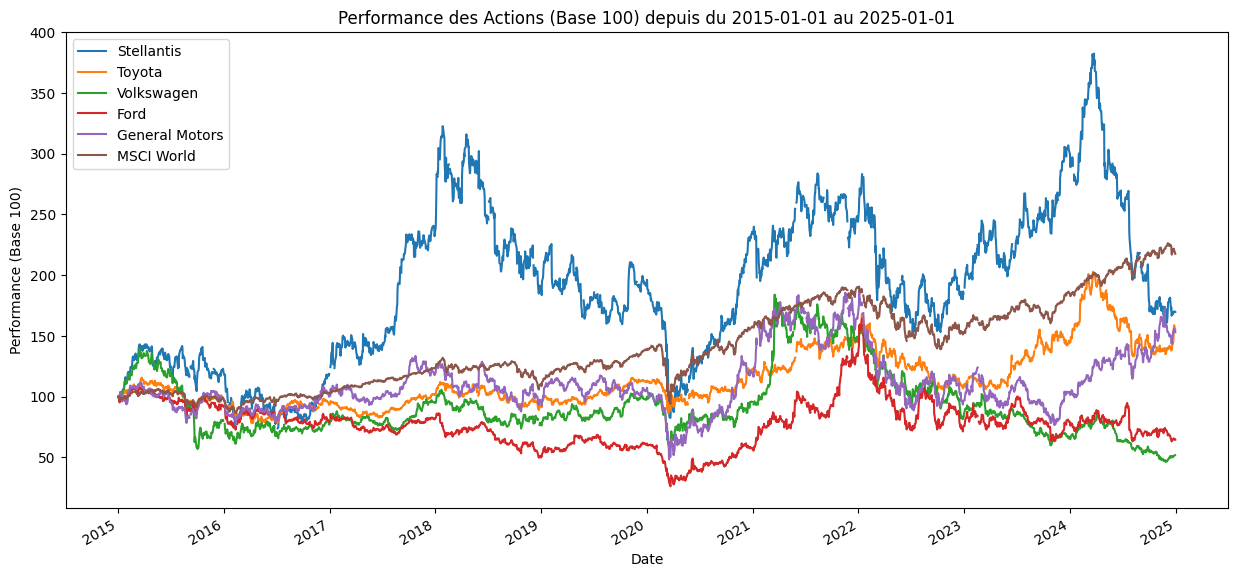

In [ ]:
# Graphique 1: Performance des actions
(df2 / df2.iloc[0] * 100).plot(figsize=(15, 7))
plt.title(f'Performance des Actions (Base 100) depuis du {start_date} au {end_date}')
plt.xlabel('Date')
plt.ylabel('Performance (Base 100)')

## **5.2. Graphique 2: Risque vs Rendement**

/var/folders/jz/vlnsqnl50w13rpz964my6q4m0000gn/T/ipykernel_18519/3946714026.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (analysis_results['Risque (Volatilité)'][i], analysis_results['Rendement Annualisé'][i]),


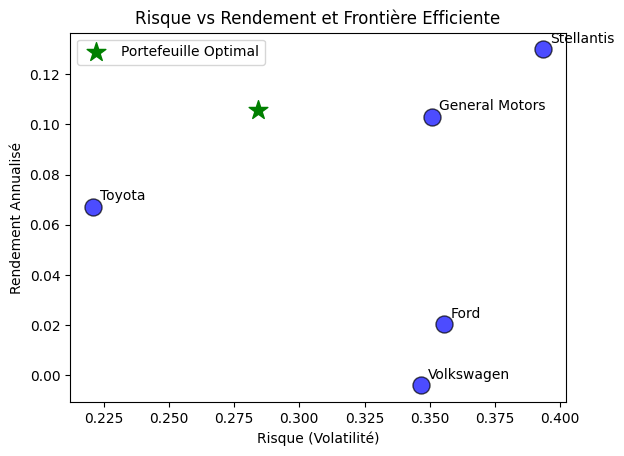

In [ ]:
# Graphique 2: Risque vs Rendement
plt.size = (15, 7)
plt.scatter(analysis_results['Risque (Volatilité)'], analysis_results['Rendement Annualisé'],s=150, c='blue', alpha=0.7, edgecolors='black')
for i, txt in enumerate(names):
    plt.annotate(txt, (analysis_results['Risque (Volatilité)'][i], analysis_results['Rendement Annualisé'][i]),
                 xytext=(5, 5), textcoords='offset points')
plt.plot(efficient_risks, efficient_returns, 'r-', linewidth=2)
plt.scatter(portfolio_risk, portfolio_return, s=200, c='green', marker='*', label='Portefeuille Optimal')
plt.title('Risque vs Rendement et Frontière Efficiente')
plt.xlabel('Risque (Volatilité)')
plt.ylabel('Rendement Annualisé')
plt.legend()

## **5.3. Graphique 3: Allocation du portefeuille optimal**

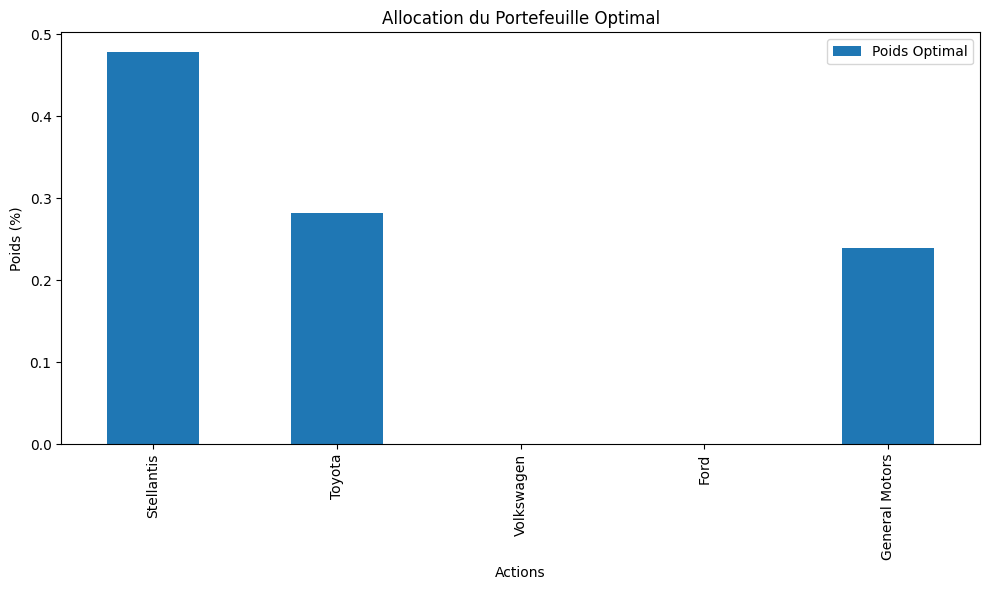

In [ ]:
# Graphique 3: Allocation du portefeuille optimal
optimal_portfolio.plot(kind='bar', figsize=(10, 6))
plt.title('Allocation du Portefeuille Optimal')
plt.xlabel('Actions')
plt.ylabel('Poids (%)')

plt.tight_layout()
plt.show()

## **5.4. Graphique 4 : Visualisation des prix du portefeuille**

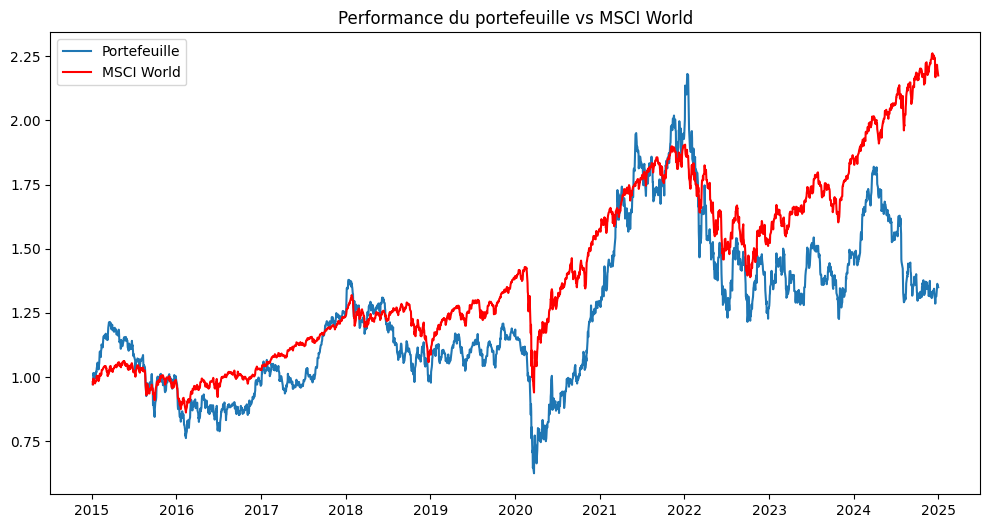

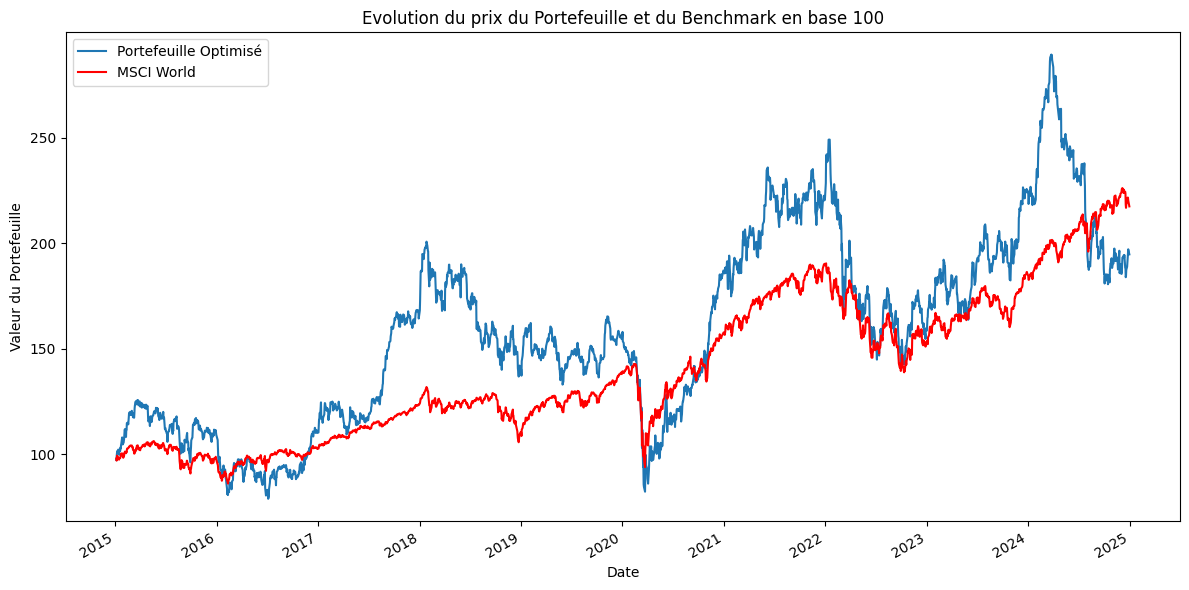

In [ ]:
#Graphique de l'évolution base 100 du porte-feuille avec le benchmark MSCI World
portfolio_value = (1 + returns.dot(sample_weights)).cumprod()
portfolio_value2 = (1 + returns2['MSCI World']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portefeuille')
plt.plot(portfolio_value2, label='MSCI World', color='red')
plt.title('Performance du portefeuille vs MSCI World')
plt.legend()
plt.show()

# Evolution du prix du portefeuille en base 100
plt.figure(figsize=(12, 6))
portfolio_cumulative_100 = portfolio_cumulative * 100 # Pour afficher en base 100
portfolio_cumulative_100.plot(label='Portefeuille Optimisé')
benchmark_cumulative_100 = (1 + returns2[benchmark_name]).cumprod() * 100
benchmark_cumulative_100.plot(label=benchmark_name, color="red")
plt.legend()

plt.title('Evolution du prix du Portefeuille et du Benchmark en base 100')
plt.xlabel('Date')
plt.ylabel('Valeur du Portefeuille')
plt.legend()
plt.tight_layout()
plt.show()

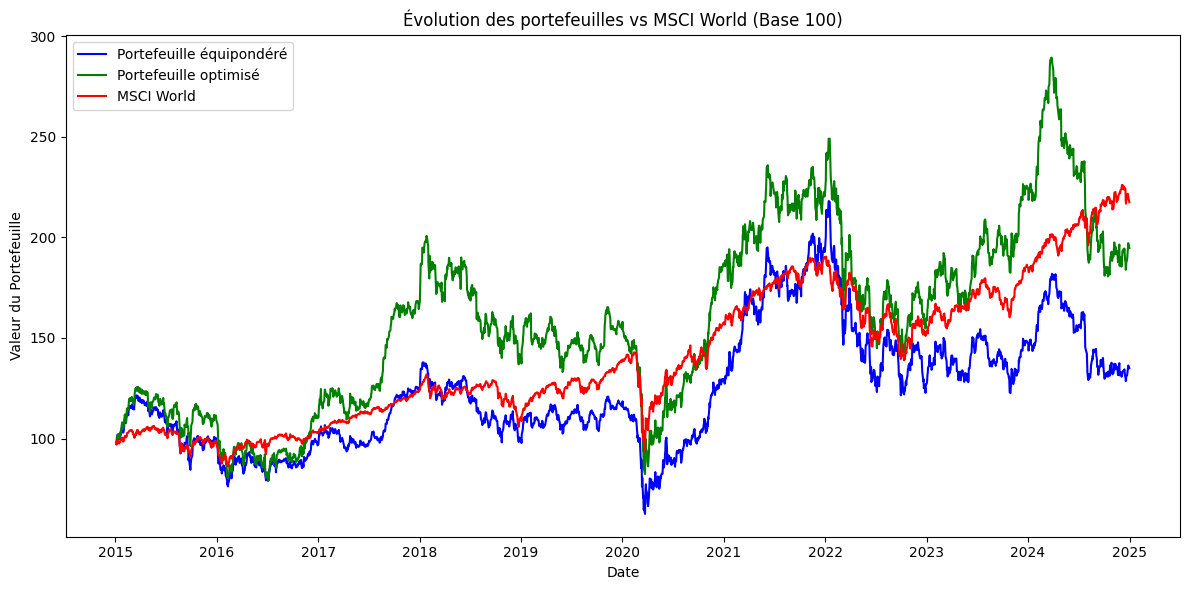

In [245]:
# Calcul des valeurs en base 100
portfolio_value = (1 + returns.dot(sample_weights)).cumprod() * 100
portfolio_value2 = (1 + returns2['MSCI World']).cumprod() * 100
portfolio_cumulative_100 = portfolio_cumulative * 100  
benchmark_cumulative_100 = (1 + returns2[benchmark_name]).cumprod() * 100

# Création du graphique combiné
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portefeuille équipondéré', color='blue')
plt.plot(portfolio_cumulative_100, label='Portefeuille optimisé', color='green')
plt.plot(benchmark_cumulative_100, label=benchmark_name, color='red')

# Mise en forme
plt.title('Évolution des portefeuilles vs MSCI World (Base 100)')
plt.xlabel('Date')
plt.ylabel('Valeur du Portefeuille')
plt.legend()
plt.tight_layout()
plt.show()

## **5.5. Matrice de corrélation**

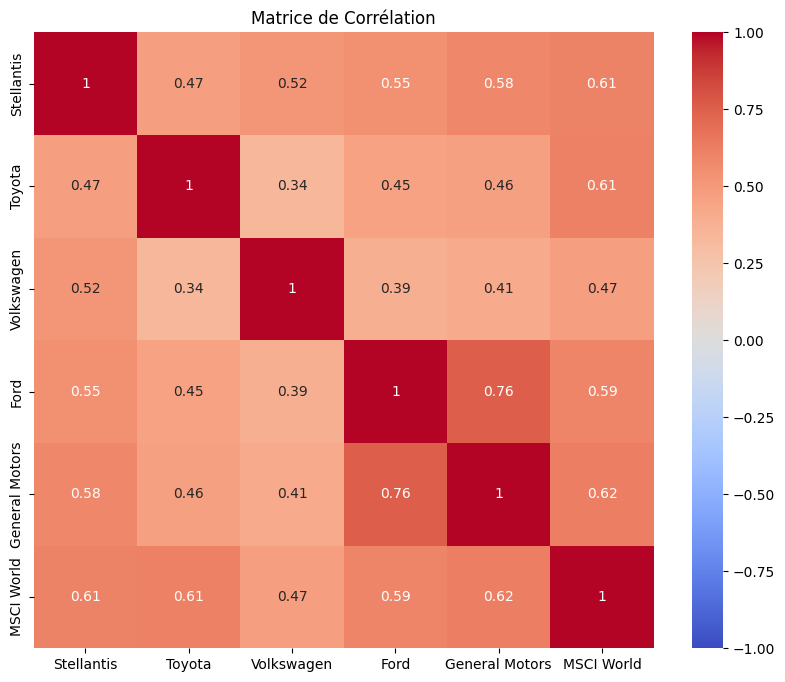

In [246]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = returns2.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

## **5.6. Analyse statistique avancée**

In [247]:
# Analyse statistique avancée: Rolling statistics
window = 252  # Fenêtre d'un an pour les statistiques glissantes

<Figure size 1500x700 with 0 Axes>

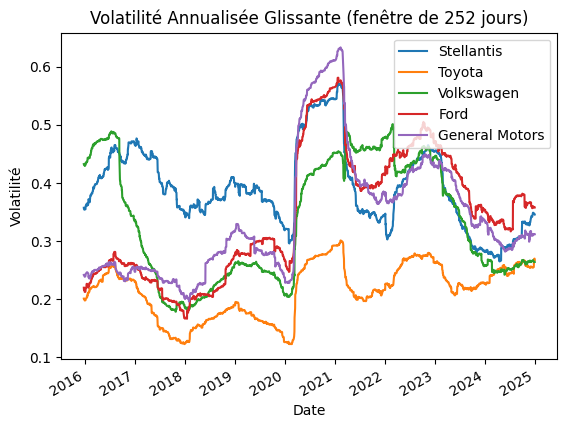

In [ ]:
# Créer des figures pour les statistiques glissantes

#Volatilité glissante
plt.figure(figsize=(15, 7))
returns.rolling(window=window).std().mul(np.sqrt(252)).plot()
plt.title(f'Volatilité Annualisée Glissante (fenêtre de {window} jours)')
plt.ylabel('Volatilité')
plt.show()

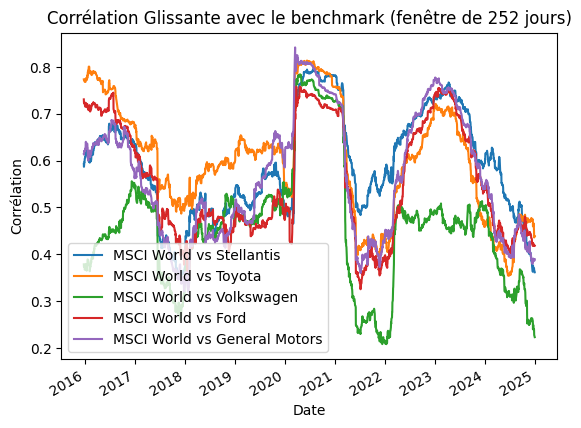

In [249]:
# Corrélation glissante avec le benchmark
for col in returns.columns:
    if col != 'MSCI':
        returns2['MSCI World'].rolling(window=window).corr(returns2[col]).plot(label=f'MSCI World vs {col}')
plt.size = (20, 10)
plt.title(f'Corrélation Glissante avec le benchmark (fenêtre de {window} jours)')
plt.ylabel('Corrélation')
plt.legend()

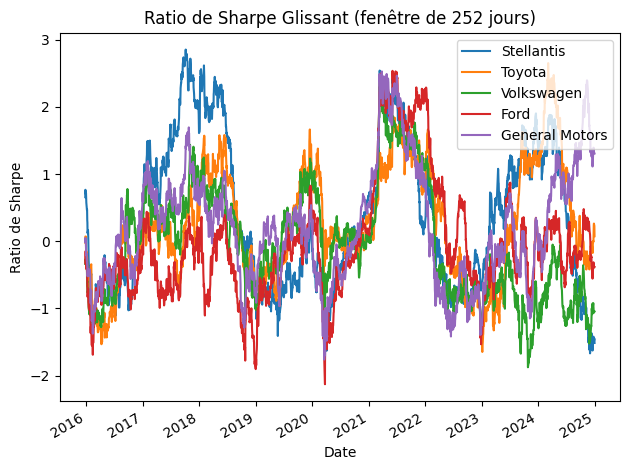

In [250]:
# Ratio de Sharpe glissant
for col in returns.columns:
    rolling_return = returns[col].rolling(window=window).mean() * 252
    rolling_vol = returns[col].rolling(window=window).std() * np.sqrt(252)
    # Calculate the Sharpe Ratio first and then plot it
    sharpe_ratio = (rolling_return - risk_free_rate) / rolling_vol
    sharpe_ratio.plot(label=col)
plt.title(f'Ratio de Sharpe Glissant (fenêtre de {window} jours)')
plt.ylabel('Ratio de Sharpe')
plt.legend()
plt.size = (10, 20)

plt.tight_layout()
plt.show()

In [253]:
# Afficher les résultats
print("\n=== Analyse des Actions Individuelles ===")
print(analysis_results.round(4))

print("\n=== Portefeuille Optimal ===")
print(optimal_portfolio.round(4))
print(f"\nRendement annualisé du portefeuille: {portfolio_return:.4f}")
print(f"Risque du portefeuille: {portfolio_risk:.4f}")
print(f"Ratio de Sharpe du portefeuille: {portfolio_sharpe:.4f}")


=== Analyse des Actions Individuelles ===
                Rendement Annualisé  Risque (Volatilité)  Ratio de Sharpe  \
Stellantis                   0.1298               0.3936           0.2663   
Toyota                       0.0670               0.2207           0.1904   
Volkswagen                  -0.0040               0.3468          -0.0836   
Ford                         0.0203               0.3554          -0.0132   
General Motors               0.1029               0.3507           0.2221   

                  Beta   Alpha  Rendement Total (%)  
Stellantis      1.2530  0.0268              69.6835  
Toyota          0.5543  0.0075              54.8580  
Volkswagen      0.9331 -0.0871                  NaN  
Ford            1.1258 -0.0748             -35.5469  
General Motors  1.1338  0.0073              52.8990  

=== Portefeuille Optimal ===
                Poids Optimal
Stellantis             0.4784
Toyota                 0.2822
Volkswagen             0.0000
Ford                

In [252]:
# Calculer les rendements mensuels pour une analyse de performance plus détaillée
monthly_returns = returns2.resample('M').apply(lambda x: (1 + x).prod() - 1)
print("\n=== Statistiques Mensuelles ===")
print(f"Meilleur mois: {monthly_returns.max().round(4)}")
print(f"Pire mois: {monthly_returns.min().round(4)}")
print(f"Mois positifs: {(monthly_returns > 0).sum()}")
print(f"Mois négatifs: {(monthly_returns < 0).sum()}")


=== Statistiques Mensuelles ===
Meilleur mois: Stellantis        0.3548
Toyota            0.2046
Volkswagen        0.5963
Ford              0.3199
General Motors    0.2696
MSCI World        0.1266
dtype: float64
Pire mois: Stellantis       -0.4220
Toyota           -0.1327
Volkswagen       -0.3704
Ford             -0.3060
General Motors   -0.3187
MSCI World       -0.1347
dtype: float64
Mois positifs: Stellantis        62
Toyota            60
Volkswagen        56
Ford              57
General Motors    62
MSCI World        76
dtype: int64
Mois négatifs: Stellantis        58
Toyota            60
Volkswagen        64
Ford              63
General Motors    58
MSCI World        44
dtype: int64


/var/folders/jz/vlnsqnl50w13rpz964my6q4m0000gn/T/ipykernel_18519/2263142445.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns2.resample('M').apply(lambda x: (1 + x).prod() - 1)
